#### This file has code to train the model and evaluate.

First read the backed-up data files into numpy arrays.

In [1]:
import pickle
import numpy as np

x_train, y_train = pickle.load(open('../outputs/train_xy_no_sampling_stdScale.pk', 'rb'))
x_cv, y_cv = pickle.load(open('../outputs/val_xy_no_sampling_stdScale.pk', 'rb'))
x_test, y_test = pickle.load(open('../outputs/test_xy_no_sampling_stdScale.pk', 'rb'))
print('shapes of train, validation, test data', x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)
values, counts = np.unique(y_train, return_counts=True)
num_features = x_train.shape[1]
print('Frequency of distance values before sampling', values, counts)

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/train_xy_no_sampling_stdScale.pk'

Since data is massively imbalanced, let's oversample the minority targets and undersample the majority type samples. The fraction for over/under sampling (0.7) was chosen with intuition and gut feeling. Feel free to play around.

In [29]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, TomekLinks, RandomUnderSampler
from imblearn.over_sampling import KMeansSMOTE, SMOTE

seed_random = 9999
# max_idx = np.argmax(counts)
# max_value = counts[max_idx]
# majority_class = values[max_idx]

x = int(counts[2]*0.7)
y = int(0.7 * x)

undersample_dict = {2:y, 3:x}
under_sampler = RandomUnderSampler(sampling_strategy=undersample_dict, random_state=seed_random)  #  n_jobs=15,
x_train, y_train = under_sampler.fit_resample(x_train, y_train.astype(np.int))
print('Frequency of distance values after undersampling', np.unique(y_train, return_counts=True))

minority_samples = int(0.7*x)
oversample_dict = {1:minority_samples, 4:minority_samples, 5:minority_samples, 6:minority_samples, 7:minority_samples}
over_sampler = RandomOverSampler(sampling_strategy=oversample_dict, random_state=seed_random)  # ,n_jobs=15, k_neighbors= 5
x_train, y_train = over_sampler.fit_resample(x_train, y_train.astype(np.int))
print('Frequency of distance values after oversampling', np.unique(y_train, return_counts=True))

pickle.dump((x_train, y_train), open('../outputs/train_xy_combine_sampling.pk', 'wb'))

x_train.shape, y_train.shape

Frequency of distance values after undersampling (array([1, 2, 3, 4, 5, 6, 7]), array([  6030, 148719, 212456,  59309,   6048,    506,     22],
      dtype=int64))
Frequency of distance values after oversampling (array([1, 2, 3, 4, 5, 6, 7]), array([148719, 148719, 212456, 148719, 148719, 148719, 148719],
      dtype=int64))


((1104770, 128), (1104770,))

In [23]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))
# y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
# y_cv = scaler.transform(y_cv.reshape(-1, 1)).flatten()
# y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

In [30]:
from utils import *
import numpy as np

np.random.seed(999)
x_train, y_train = unison_shuffle_copies(x_train, y_train)

#### Creating a baseline for this dataset by training a Linear Regression model.

In [12]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1).fit(x_train, y_train)

In [13]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

y_pred = baseline_model.predict(x_test)
y_class = np.round(y_pred)
baseline_acc = accuracy_score(y_test, y_class)*100
baseline_mse = mean_squared_error(y_test, y_pred)
baseline_mae = mean_absolute_error(y_test, y_pred)
print("Baseline: Accuracy={}%, MSE={}, MAE={}".format(round(baseline_acc, 2), round(baseline_mse,2), round(baseline_mae,2)))

Baseline: Accuracy=50.57%, MSE=0.55, MAE=0.59


Linear Regression does surprisingly good! 50% is a good baseline to compare with, considering that chance prediction in this case is ~14% (1/7). This concludes setting the baseline for this problem. We will compare our neural network results with this to see how much we have improved.

Feature selection with XGboost (Not used now. This didn't help much with the results. May be trying out other feature selection algorithms could help.)

In [ ]:
# x_train_org = x_train.copy()
# x_cv_org = x_cv.copy()
# x_test_org = x_test.copy()

In [ ]:
# from xgboost import XGBRegressor
# from xgboost import plot_importance
# from sklearn.feature_selection import SelectFromModel
# from matplotlib import pyplot as plt
# from sklearn.feature_selection import SelectPercentile

# xgbReg = XGBRegressor(objective="count:poisson", tree_method='gpu_hist', gpu_id=0)
# xgbReg.fit(x_train, y_train)
# plot_importance(xgbReg, max_num_features=30)
# plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score
# y_pred = xgbReg.predict(x_test)
# f'xgboost accuracy is {accuracy_score(y_test, np.round(y_pred))}'

In [ ]:
# selectFeature = SelectFromModel(xgbReg, prefit=True, threshold="median")
# selectFeature.transform(x_train_org)
# feature_mask = selectFeature.get_support()
# num_features = np.sum(feature_mask)
# x_train = x_train_org[:, feature_mask]
# x_cv = x_cv_org[:, feature_mask]
# x_test = x_test_org[:, feature_mask]
# print(f'{num_features} number of feature selected, shape of train data is {x_train.shape}')

In [31]:
params = {'batch_size': 1000, 'input_size': num_features, 'hidden_units_1': 200, 'hidden_units_2': 100, 'hidden_units_3': 50, 'do_1': 0.2, 'do_2': 0.1, 'do_3': 0.05, 'output_size': 1, 'lr': 0.001, 'min_lr': 1e-5, 'max_lr': 1e-3, 'epochs': 500, 'lr_sched': 'clr', 'lr_sched_mode': 'triangular', 'gamma': 0.95}

params

{'batch_size': 1000,
 'input_size': 128,
 'hidden_units_1': 200,
 'hidden_units_2': 100,
 'hidden_units_3': 50,
 'do_1': 0.2,
 'do_2': 0.1,
 'do_3': 0.05,
 'output_size': 1,
 'lr': 0.001,
 'min_lr': 1e-05,
 'max_lr': 0.001,
 'epochs': 500,
 'lr_sched': 'clr',
 'lr_sched_mode': 'triangular',
 'gamma': 0.95}

Create pytorch data loaders for train/val/test datasets.

In [32]:
import torch
from torch.utils import data as torch_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

trainset = torch_data.TensorDataset(torch.as_tensor(x_train, dtype=torch.float, device=device), torch.as_tensor(y_train, dtype=torch.float, device=device))
train_dl = torch_data.DataLoader(trainset, batch_size=params['batch_size'], drop_last=True)

val_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_cv, dtype=torch.float, device=device), torch.as_tensor(y_cv, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

test_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_test, dtype=torch.float, device=device), torch.as_tensor(y_test, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

device: cuda:0


Check for batches with all same type of samples (same distance values). This issues had caused me a lot of grief.

In [52]:
print('value counts in whole data', np.unique(y_train, return_counts=True))
count = 0
for i, data in enumerate(train_dl, 0):
    input, target = data[0], data[1]
    t = torch.unique(target, return_counts=True)[1]
    if (t==params['batch_size']).any().item():
        count += 1
print('{} ({}%) batches have all same targets'.format(count, np.round(count/len(train_dl)*100, 2) ))

value counts in whole data (array([1, 2, 3, 4, 5, 6, 7]), array([148719, 148719, 212456, 148719, 148719, 148719, 148719],
      dtype=int64))
0 (0.0%) batches have all same targets


Initialize model, loss, learning rate schedulers etc

In [33]:
from torchsummary import summary
import sys
import io

torch.manual_seed(9999)
def get_model():
    """
    creates a PyTorch model. Change the 'params' dict above to 
    modify the neural net configuration.
    """
    model = torch.nn.Sequential(
        torch.nn.Linear(params['input_size'], params['hidden_units_1']),
        torch.nn.BatchNorm1d(params['hidden_units_1']),
        # torch.nn.Dropout(p=params['do_1']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_1'], params['hidden_units_2']),
        torch.nn.BatchNorm1d(params['hidden_units_2']),
        # torch.nn.Dropout(p=params['do_2']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_2'], params['hidden_units_3']),
        torch.nn.BatchNorm1d(params['hidden_units_3']),
        # torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_3'], params['output_size']),
        torch.nn.ReLU(),
        # torch.nn.Softplus(),
    )
    model.to(device)
    return model

def poisson_loss(y_pred, y_true):
    """
    Custom loss function for Poisson model.
    Equivalent Keras implementation for reference:
    K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)
    For output of shape (2,3) it return (2,) vector. Need to calculate
    mean of that too.
    """
    y_pred = torch.squeeze(y_pred)
    loss = torch.mean(y_pred - y_true * torch.log(y_pred+1e-7))
    return loss

model = get_model()

print('model loaded into device=', next(model.parameters()).device)

# this is just to capture model summary as string
old_stdout = sys.stdout
sys.stdout = buffer = io.StringIO()

summary(model, input_size=(params['input_size'], ))

sys.stdout = old_stdout
model_summary = buffer.getvalue()
print('model-summary\n', model_summary)
# later this 'model-summary' string can be written to tensorboard

lr_reduce_patience = 20
lr_reduce_factor = 0.1

loss_fn = poisson_loss
# optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9, dampening=0, weight_decay=0, nesterov=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=params['lr'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

if params['lr_sched'] == 'reduce_lr_plateau':
    lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_reduce_factor, patience=lr_reduce_patience, verbose=True, threshold=0.00001, threshold_mode='rel', cooldown=0, min_lr=1e-9, eps=1e-08)
elif params['lr_sched'] == 'clr':
    lr_sched = torch.optim.lr_scheduler.CyclicLR(optimizer, params['min_lr'], params['max_lr'], step_size_up=8*len(train_dl), step_size_down=None, mode=params['lr_sched_mode'], last_epoch=-1, gamma=params['gamma'])

print('lr scheduler type:', lr_sched)
for param_group in optimizer.param_groups:
    print(param_group['lr'])

model loaded into device= cuda:0
model-summary
 ----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]          25,800
       BatchNorm1d-2                  [-1, 200]             400
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 100]          20,100
       BatchNorm1d-5                  [-1, 100]             200
              ReLU-6                  [-1, 100]               0
            Linear-7                   [-1, 50]           5,050
       BatchNorm1d-8                   [-1, 50]             100
              ReLU-9                   [-1, 50]               0
           Linear-10                    [-1, 1]              51
             ReLU-11                    [-1, 1]               0
Total params: 51,701
Trainable params: 51,701
Non-trainable params: 0
-------------------------------------------------

#### Run next cell to find optimal range for learning rate while using One-Cycle LR scheduler
In this case choosing the learning rate from graph below didn't help. You can skip this cell if not required.

In [ ]:
#### from https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

import math

lr_arr = np.zeros((len(train_dl), ))

def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
    global lr_arr
    num = len(train_dl)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    lrs = []
    for data in train_dl:
        batch_num += 1
        # As before, get the loss for this mini-batch of inputs/outputs
        inputs, labels = data
        # inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        # Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        # Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        lrs.append(lr)
        lr_arr[batch_num-1] = lr
        # Do the SGD step
        loss.backward()
        optimizer.step()
        # Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

lrs, losses = find_lr()
print('returned', len(losses))
plt.figure()
plt.plot(lr_arr[:len(lrs)], losses)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.title('LR range plot')
plt.xlabel('Learning rates')
plt.ylabel('Losses')
plt.show()

In [34]:
def evaluate(model, dl):
    """
    This function is used to evaluate the model with validation.
    args: model and data loader
    returns: loss
    """
    model.eval()
    final_loss = 0.0
    count = 0
    with torch.no_grad():
        for data_cv in dl:
            inputs, dist_true = data_cv[0], data_cv[1]
            count += len(inputs)
            outputs = model(inputs)
            loss = loss_fn(outputs, dist_true)
            final_loss += loss.item()
    return final_loss/len(dl)

def save_checkpoint(state, state_save_path):
    if not os.path.exists("/".join(state_save_path.split('/')[:-1])):
        os.makedirs("/".join(state_save_path.split('/')[:-1]))
    torch.save(state, state_save_path)

Below cell trains the model and records the results in tensorboard.

In [35]:
%%time
# %load_ext tensorboard

import time
import copy
from tqdm.auto import tqdm
from utils import *
from torch.utils.tensorboard import SummaryWriter
# from tensorboardX import SummaryWriter

last_loss = 0.0
min_val_loss = np.inf
patience_counter = 0
early_stop_patience = 50
best_model = None
train_losses = []
val_losses = []

output_path = '../outputs'
tb_path = output_path+'/logs/runs'
run_path = tb_path+'/run47_smallerNN_noDO'
checkpoint_path = run_path+'/checkpoints'
resume_training = False
start_epoch = 0
iter_count = 0

if os.path.exists(run_path):
    raise Exception("this experiment already exists!")

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

writer = SummaryWriter(log_dir=run_path, comment='', purge_step=None, max_queue=1, flush_secs=30, filename_suffix='')
writer.add_graph(model, input_to_model=torch.zeros(params['input_size']).view(1,-1).cuda(), verbose=False)  # not useful

# resume training on a saved model
if resume_training:
    prev_checkpoint_path = '../outputs/logs/runs/run42_clr_g0.95/checkpoints'  # change this
    suffix = '1592579305.7273214'  # change this
    model.load_state_dict(torch.load(prev_checkpoint_path+'/model_'+suffix+'.pt'))
    optimizer.load_state_dict(torch.load(prev_checkpoint_path+'/optim_'+suffix+'.pt'))
    lr_sched.load_state_dict(torch.load(prev_checkpoint_path+'/sched_'+suffix+'.pt'))
    state = torch.load(prev_checkpoint_path+'/state_'+suffix+'.pt') 
    start_epoch = state['epoch']
    writer.add_text('loaded saved model:', str(params))
    print('loaded saved model', params)

writer.add_text('run_change', 'Smaller 3 hidden layer NN, no DO' + str(params))

torch.backends.cudnn.benchmark = True
print('total epochs=', len(range(start_epoch, start_epoch+params['epochs'])))

# with torch.autograd.detect_anomaly():  # use this to detect bugs while training
for param_group in optimizer.param_groups:
    print('lr-check', param_group['lr'])
for epoch in range(start_epoch, start_epoch+params['epochs']):  # loop over the dataset multiple times
    running_loss = 0.0
    stime = time.time()
    
    for i, data in enumerate(train_dl, 0):
        iter_count += 1
        # get the inputs; data is a list of [inputs, dist_true]
        model.train()
        inputs, dist_true = data[0], data[1]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, dist_true)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        last_loss = loss.item()

        for param_group in optimizer.param_groups:
            curr_lr = param_group['lr']
        writer.add_scalar('monitor/lr-iter', curr_lr, iter_count-1)

        if not isinstance(lr_sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_sched.step()

    val_loss = evaluate(model, val_dl)
    if isinstance(lr_sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
        lr_sched.step(val_loss)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
        best_model = copy.deepcopy(model)
        print(epoch,"> Best val_loss model saved:", round(val_loss, 4))
    else:
        patience_counter += 1
    train_loss = running_loss/len(train_dl)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    writer.add_scalar('loss/train', train_loss, epoch)
    writer.add_scalar('loss/val', val_loss, epoch)
    for param_group in optimizer.param_groups:
        curr_lr = param_group['lr']
    writer.add_scalar('monitor/lr-epoch', curr_lr, epoch)
    if patience_counter > early_stop_patience:
        print("Early stopping at epoch {}. current val_loss {}".format(epoch, val_loss))
        break

    if epoch % 10 == 0:
        torch.save(best_model.state_dict(), checkpoint_path+'/model_cp.pt')
        torch.save(optimizer.state_dict(), checkpoint_path+'/optim_cp.pt')
        torch.save(lr_sched.state_dict(), checkpoint_path+'/sched_cp.pt')
        writer.add_text('checkpoint saved', 'at epoch='+str(epoch))
        print("epoch:{} -> train_loss={},val_loss={} - {}".format(epoch, round(train_loss, 5),round(val_loss, 5), seconds_to_minutes(time.time()-stime)))

print('Finished Training')
ts = str(time.time())
best_model_path = checkpoint_path+'/model_'+ts+'.pt'
opt_save_path = checkpoint_path+'/optim_'+ts+'.pt'
sched_save_path = checkpoint_path+'/sched_'+ts+'.pt'
state_save_path = checkpoint_path+'/state_'+ts+'.pt'
state = {'epoch': epoch+1,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict(),
        'last_train_loss': train_losses[-1],
        'last_val_loss': val_losses[-1],
        'total_iters': iter_count
        }

save_checkpoint(state, state_save_path)
# sometimes loading from state dict is not wokring, so...
torch.save(best_model.state_dict(), best_model_path)
torch.save(optimizer.state_dict(), opt_save_path)
torch.save(lr_sched.state_dict(), sched_save_path)

# run44 val = -0.1126
# Top runs: run44, run26, run21, run20, run19_batch_norm_other_changes, run18_trngl2, run10_3

total epochs= 500
lr-check 1e-05
0 > Best val_loss model saved: -0.0781
epoch:0 -> train_loss=1.9969,val_loss=-0.07814 - 0.0 minutes 42.0 seconds
1 > Best val_loss model saved: -0.0936
2 > Best val_loss model saved: -0.0975
3 > Best val_loss model saved: -0.1022
4 > Best val_loss model saved: -0.103
5 > Best val_loss model saved: -0.1042
6 > Best val_loss model saved: -0.1051
7 > Best val_loss model saved: -0.1059
8 > Best val_loss model saved: -0.1068
9 > Best val_loss model saved: -0.1075
10 > Best val_loss model saved: -0.108
epoch:10 -> train_loss=-1.97189,val_loss=-0.10803 - 0.0 minutes 41.0 seconds
11 > Best val_loss model saved: -0.1085
12 > Best val_loss model saved: -0.1091
13 > Best val_loss model saved: -0.1098
15 > Best val_loss model saved: -0.111
epoch:20 -> train_loss=-1.97394,val_loss=-0.10876 - 0.0 minutes 42.0 seconds
epoch:30 -> train_loss=-1.97593,val_loss=-0.11001 - 0.0 minutes 42.0 seconds
31 > Best val_loss model saved: -0.1116
epoch:40 -> train_loss=-1.97498,val

Now test the model with test data.

In [36]:
def test(model, dl):
    model.eval()
    final_loss = 0.0
    count = 0
    y_hat = []
    with torch.no_grad():
        for data_cv in dl:
            inputs, dist_true = data_cv[0], data_cv[1]
            count += len(inputs)
            outputs = model(inputs)
            y_hat.extend(outputs.tolist())
            loss = loss_fn(outputs, dist_true)
            final_loss += loss.item()
    return final_loss/len(dl), y_hat

model.load_state_dict(torch.load(best_model_path)) 
test_loss, y_hat = test(model, test_dl)
print(test_loss)
writer.add_text('test-loss', str(test_loss))
try:
    if scaler:
        y_hat = scaler.inverse_transform(y_hat)
        y_test = scaler.inverse_transform(y_test)
except:
    pass
y_hat[50:60], y_test[50:60]

-0.1114755342913489


([[2.496044874191284],
  [5.338737964630127],
  [2.889045476913452],
  [3.3817601203918457],
  [3.0526061058044434],
  [2.8420331478118896],
  [3.8574349880218506],
  [2.924955368041992],
  [2.0410168170928955],
  [1.9254369735717773]],
 array([2, 4, 3, 3, 3, 3, 4, 3, 2, 2]))

In [37]:
from sklearn.metrics import accuracy_score
writer.add_text('Accuracy=', str(accuracy_score(y_test[:len(y_hat)], np.round(y_hat))))
print(str(accuracy_score(y_test[:len(y_hat)], np.round(y_hat))))

0.7640170940170941


234489 234000


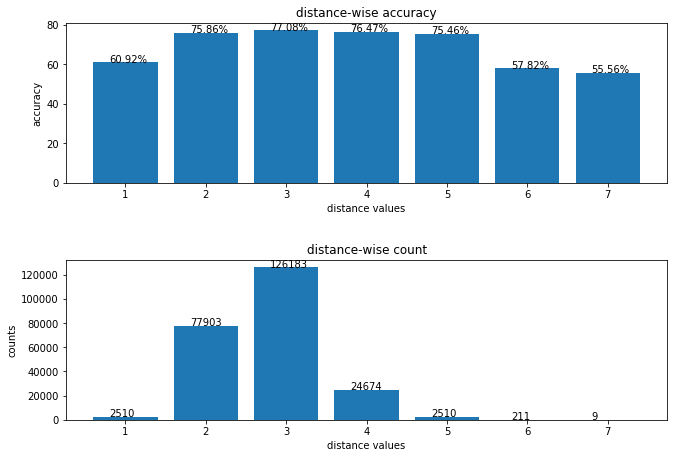

class avg accuracy 68.4511535029418
MSE 0.17543498341168126
MAE 0.3216275359218956


In [38]:
# show distance value wise precision (bar chart)
# predicted values are less that real test samples because last samples from test are dropped to maintain same batch size (drop_last=True)
from matplotlib import pyplot as plt

y_hat_ = np.array(y_hat).squeeze()
y_test_ = y_test[:len(y_hat)]
print(len(y_test), len(y_hat))
dist_accuracies = []
dist_counts = [] 
for i in range(1, 8):
    mask = y_test_==i
    dist_values = y_test_[mask]
    dist_preds = np.round(y_hat_[mask])
    dist_accuracies.append(np.sum(dist_values == dist_preds)*100/len(dist_values))
    dist_counts.append(len(dist_values))

fig = plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.bar(range(1,8), dist_accuracies)
for index, value in enumerate(dist_accuracies):
    plt.text(index+0.8, value, str(np.round(value, 2))+'%')
plt.title('distance-wise accuracy')
plt.xlabel('distance values')
plt.ylabel('accuracy')
plt.subplot(2,1,2)
plt.bar(range(1,8), dist_counts)
for index, value in enumerate(dist_counts):
    plt.text(index+0.8, value, str(value))
plt.title('distance-wise count')
plt.xlabel('distance values')
plt.ylabel('counts')
fig.tight_layout(pad=3.0)
plt.show()
writer.add_figure('test/results', fig)
writer.add_text('class avg accuracy', str(np.mean(dist_accuracies)))
print('class avg accuracy', np.mean(dist_accuracies))

writer.add_text('MSE', str(np.mean((np.array(y_hat).squeeze()-y_test[:len(y_hat)])**2)))
print('MSE', np.mean((np.array(y_hat).squeeze()-y_test[:len(y_hat)])**2))

writer.add_text('MAE', str(np.mean(np.abs(np.array(y_hat).squeeze() - y_test[:len(y_hat)]))))
print('MAE', np.mean(np.abs(np.array(y_hat).squeeze() - y_test[:len(y_hat)])))

In [12]:
writer.add_text('ending_remark', 'no dropout caused faster training but final val error/accuracy was worse than with-do training')

In [39]:
# to shutdown system once training is over. For over-night training sessions.
os.system("shutdown /s /t 100") 

0

In [81]:
# to abort shutdown timer
os.system("shutdown /a")

0

#### Following cells can be ignored. Includes some rough works and old TODO lists.

Since training is the model gives poor results, try to figure out the issue. Train with small number of samples from one distance value then add other values.

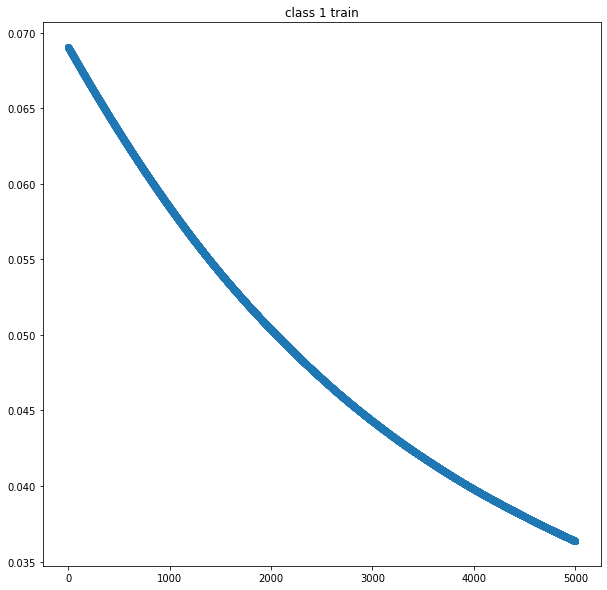

0.03635319322347641
4.0 -- 3.92393159866333
4.0 -- 3.562809944152832
4.0 -- 3.0581398010253906
4.0 -- 4.3185882568359375
2.0 -- 1.9316364526748657
1.0 -- 1.0718663930892944
4.0 -- 4.211127281188965
2.0 -- 2.1172752380371094
2.0 -- 2.2493553161621094
4.0 -- 4.741888046264648
1.0 -- 1.1426559686660767
2.0 -- 1.9122633934020996
1.0 -- 1.095723271369934
2.0 -- 1.9441494941711426
2.0 -- 2.2417829036712646
2.0 -- 2.2907915115356445
4.0 -- 4.017078399658203
1.0 -- 1.0389814376831055
2.0 -- 2.011592149734497
2.0 -- 2.126307249069214


In [74]:
classes = [1, 2, 4]
x_temp = []
y_temp = []
for class_ in classes:
    x_temp.extend(x_train[y_train==class_][:100])
    y_temp.extend(y_train[y_train==class_][:100])
x_temp, y_temp = unison_shuffle_copies(np.array(x_temp), np.array(y_temp))
x_temp = torch.tensor(x_temp, dtype=torch.float32, device=device)
y_temp = torch.tensor(y_temp, dtype=torch.float32, device=device)
loss_history = []
for epoch in range(5000):  # loop over the dataset multiple times
    running_loss = 0.0
    stime = time.time()
    
    # get the inputs; data is a list of [inputs, dist_true]
    model.train()
    inputs, dist_true = x_temp, y_temp
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = loss_fn(outputs, dist_true)
    
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

from utils import *
plot(loss_history, 'class 1 train')

model.eval()
op_temp = model(x_temp)
print(loss_history[-1])
for i,j in zip(y_temp[:20], op_temp.squeeze().tolist()[:20]):
    print(i.item(), '--', j)

#### Things to try
* Next try one cycle lr sched -- 
* Distance values of 2 & 3 dominate the data. Best way to handle?
* try batch normalization
* normalize outputs?
* try Mean Absolute Error (robust to large/small outliers) and Mean Sq log error.
* are features good enough for prediction? Check it. May be try XGBoost for it.
* stratified data
* check one-cycle LR and loss correlation. Log it in tensorboard.
* print out outputs to see why loss so high?
* next try run20 with step size 8--------
* try run23 without early stop
#### from [37 checklist]('https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607')
* try under sampling
* Make sure your batches don’t contain a single label -- batches skewed like this: [  58, 1795, 2514,  551,   78,    4], There are many batches where all are '1', e.g.:
114 -- (tensor([1.], device='cuda:0'), tensor([5000], device='cuda:0'))
115 -- (tensor([1.], device='cuda:0'), tensor([5000], device='cuda:0'))
* large batch can reduce the generalization ability of the model
* check model behaviour with random data and see if it's same
* try zero mean and unit variance
* train with just 1 or 2 examples and see if your network can learn to differentiate these. Then try more.
* checkout out gradients and activations: “A good standard deviation for the activations is on the order of 0.5 to 2.0. Significantly outside of this range may indicate vanishing or exploding activations.”, https://discuss.pytorch.org/t/how-can-i-get-the-gradients-of-the-weights-of-each-layer/28502
* 33. Visualize the training
* try leakyRelu
* try training with Mean relative error

#### Observations
* Tried overfitting with small number of sample to test if model learns. Here is the result:
  1. model worked for 5 samples of target 1. pred around ~1.2  (50 epochs)
  2. model didn't work for 5 samples of 1 & 2 each. all preds ~1.5(upto 1000 epochs tried)
  3. model worked for samples with target 2 only, all preds ~2 (50 epochs)
  4. model didn't work for 5 samples of 2 & 3 each. all preds ~2.5(upto 1000 epochs tried)
  5. model didn't work for 5 samples of 1 & 6 each. all preds ~3.5(upto 1000 epochs tried)
conclusion: model works for any single distance value at a time but not multiple (always tries to predict mid value of distances, e.g. for (1,5) prediction ~3), shuffling didn't help. May be need to <b>change loss function</b> or larger NN? -- larger NN made no difference, same model (2 hidden layers, lr=0.001) with poisson loss gives great result, even without data shuffling, epochs=1000.
* Next prob--> For same config adding 100 samples of 3 distances (1,2,4) significantly reduced performance.-- training for much longer (5K epochs) improved result significantly.
So, overSample minority targets and train for long time with poisson loss.
* Run 8 was succesfull but try to improve: reduce undersample, use small dropouts
* Run 10 was even better than run8. Better distance accuracies (avg 70.5), training became painfully slow after 1600 epochs so force stopped. May be try bette LR range next? 